In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [11]:
# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

In [12]:
data = pd.read_csv('GRAPE_QUALITY.csv')
data.head()

,sample_id,variety,region,quality_score,quality_category,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,harvest_date,sun_exposure_hours,soil_moisture_percent,rainfall_mm
0,1,Riesling,Barossa Valley,2.11,Medium,13.70,3.17,251.81,18.58,2023-09-04,8.4,55.9,223.3
1,2,Pinot Noir,Loire Valley,2.83,High,20.84,3.15,289.00,22.08,2023-09-16,8.8,36.9,312.1
2,3,Sauvignon Blanc,Napa Valley,3.52,Premium,27.46,4.07,125.14,21.40,2023-08-25,11.1,64.9,698.7
3,4,Riesling,Napa Valley,2.28,Medium,24.64,3.15,237.46,12.31,2023-09-13,8.0,54.5,660.1
4,5,Merlot,Napa Valley,2.90,High,26.13,3.18,221.52,12.24,2023-08-11,11.2,36.3,410.4


In [13]:
# Encoding categorical variables
encoding_variety = {
    "Cabernet Sauvignon": 0, "Chardonnay": 1, "Merlot": 2, "Pinot Noir": 3,
    "Riesling": 4, "Sauvignon Blanc": 5, "Syrah": 6, "Zinfandel": 7
}
encoding_region = {
    "Barossa Valley": 0, "Bordeaux": 1, "Loire Valley": 2, "Mendoza": 3,
    "Napa Valley": 4, "Rioja": 5, "Sonoma": 6, "Tuscany": 7
}
encoding_quality_category = {
    "Low": 0, "Medium": 1, "High": 2, "Premium": 3
}

data['variety'] = data['variety'].map(encoding_variety)
data['region'] = data['region'].map(encoding_region)
data['quality_category'] = data['quality_category'].map(encoding_quality_category)

# Extract month from harvest_date
data['harvest_month'] = pd.to_datetime(data['harvest_date']).dt.month

# Drop unnecessary columns
data = data.drop(columns=['sample_id', 'harvest_date'])

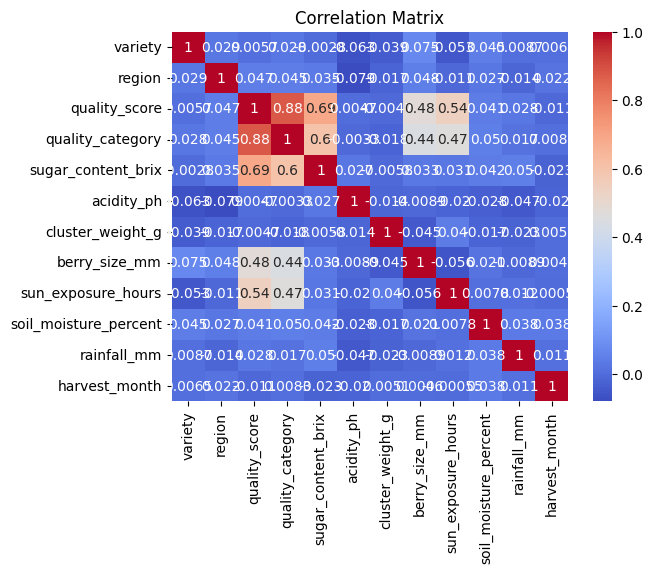

Selected Features: ['variety', 'region', 'quality_score', 'sugar_content_brix', 'acidity_ph', 'cluster_weight_g', 'berry_size_mm', 'sun_exposure_hours', 'soil_moisture_percent', 'rainfall_mm', 'harvest_month']


In [14]:
# Analyze correlation
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Select features based on correlation
threshold = 0.001
selected_features = correlation_matrix['quality_category'][abs(correlation_matrix['quality_category']) > threshold].index.tolist()
selected_features.remove('quality_category')

print(f"Selected Features: {selected_features}")

In [15]:
# Prepare dataset
X = data[selected_features]
y = data['quality_category']

# Normalization using custom Min-Max formula
def minmax_normalization(data, feature_range=(0.1, 0.9)):
    min_val = data.min()
    max_val = data.max()
    a, b = feature_range
    return (b - a) * (data - min_val) / (max_val - min_val) + a

X_normalized = X.apply(lambda col: minmax_normalization(col), axis=0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Neural network parameters
input_neurons = X_train.shape[1]
hidden_neurons = 4
output_neurons = 4

# Initialize weights and biases
np.random.seed(42)
weights_input_hidden = np.random.uniform(-1, 1, (input_neurons, hidden_neurons))
weights_hidden_output = np.random.uniform(-1, 1, (hidden_neurons, output_neurons))
bias_hidden = np.random.uniform(-1, 1, (1, hidden_neurons))
bias_output = np.random.uniform(-1, 1, (1, output_neurons))

# Training parameters
learning_rate = 0.01
epochs = 1000

# One-hot encode labels
y_train_encoded = np.zeros((y_train.size, output_neurons))
y_train_encoded[np.arange(y_train.size), y_train] = 1

In [16]:
X_normalized.head()

,variety,region,quality_score,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm,harvest_month
0,0.557143,0.100000,0.381533,0.246111,0.311429,0.638219,0.558517,0.420000,0.617293,0.130975,0.9
1,0.442857,0.328571,0.582230,0.532715,0.300000,0.737501,0.745558,0.473333,0.236341,0.249533,0.9
2,0.671429,0.557143,0.774564,0.798445,0.825714,0.300060,0.709218,0.780000,0.797744,0.765688,0.1
3,0.557143,0.557143,0.428920,0.685248,0.300000,0.599910,0.223447,0.366667,0.589223,0.714152,0.9
4,0.328571,0.557143,0.601742,0.745058,0.317143,0.557356,0.219706,0.793333,0.224311,0.380774,0.1


In [17]:
# Training the neural network
for epoch in range(epochs):
    # Forward pass
    hidden_layer_input = np.dot(X_train, weights_input_hidden) + bias_hidden
    hidden_layer_output = sigmoid(hidden_layer_input)

    output_layer_input = np.dot(hidden_layer_output, weights_hidden_output) + bias_output
    output_layer_output = sigmoid(output_layer_input)

    # Error calculation
    error = y_train_encoded - output_layer_output

    # Backpropagation
    d_output = error * sigmoid_derivative(output_layer_output)
    error_hidden_layer = d_output.dot(weights_hidden_output.T)
    d_hidden = error_hidden_layer * sigmoid_derivative(hidden_layer_output)

    # Update weights and biases
    weights_hidden_output += hidden_layer_output.T.dot(d_output) * learning_rate
    bias_output += np.sum(d_output, axis=0, keepdims=True) * learning_rate
    weights_input_hidden += X_train.T.dot(d_hidden) * learning_rate
    bias_hidden += np.sum(d_hidden, axis=0, keepdims=True) * learning_rate

    # Log progress
    if epoch % 100 == 0:
        loss = np.mean(np.abs(error))
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 0.5070
Epoch 100, Loss: 0.1849
Epoch 200, Loss: 0.1298
Epoch 300, Loss: 0.1110
Epoch 400, Loss: 0.0999
Epoch 500, Loss: 0.0923
Epoch 600, Loss: 0.0867
Epoch 700, Loss: 0.0825
Epoch 800, Loss: 0.0791
Epoch 900, Loss: 0.0763


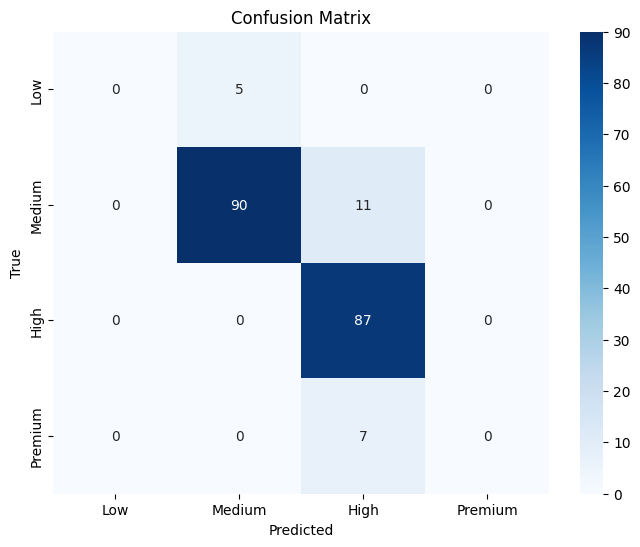

Precision (weighted): 0.8388
Recall (weighted): 0.8850
F1-Score (weighted): 0.8580


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# Evaluate on test data
hidden_layer_input_test = np.dot(X_test, weights_input_hidden) + bias_hidden
hidden_layer_output_test = sigmoid(hidden_layer_input_test)

output_layer_input_test = np.dot(hidden_layer_output_test, weights_hidden_output) + bias_output
output_layer_output_test = sigmoid(output_layer_input_test)

# Predicted classes
y_pred = np.argmax(output_layer_output_test, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoding_quality_category.keys(), yticklabels=encoding_quality_category.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Precision, Recall, F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

In [19]:
dataset = pd.concat([X, y], axis=1)
dataset.head()

,variety,region,quality_score,sugar_content_brix,acidity_ph,cluster_weight_g,berry_size_mm,sun_exposure_hours,soil_moisture_percent,rainfall_mm,harvest_month,quality_category
0,4,0,2.11,13.70,3.17,251.81,18.58,8.4,55.9,223.3,9,1
1,3,2,2.83,20.84,3.15,289.00,22.08,8.8,36.9,312.1,9,2
2,5,4,3.52,27.46,4.07,125.14,21.40,11.1,64.9,698.7,8,3
3,4,4,2.28,24.64,3.15,237.46,12.31,8.0,54.5,660.1,9,1
4,2,4,2.90,26.13,3.18,221.52,12.24,11.2,36.3,410.4,8,2


In [20]:
#dataset.to_csv('dataset_processed.csv', index=False)